#**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#**Setting Directory Path**

In [ ]:
cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


#**Importing Libraries**

In [ ]:
import os
import cv2
import math
import glob
import keras
import random
import warnings
import tensorflow as tf
# warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Layer
from skimage.filters import threshold_otsu
from skimage import measure

#**Loading The Dataset**

In [ ]:
IMAGE_SIZE = [224,224]

train_path = '/content/drive/MyDrive/dataset/Data/train'
test_path = '/content/drive/MyDrive/dataset/Data/test'
val_path  = '/content/drive/MyDrive/dataset/Data/valid'

SIZE = 64
X = []
Y = []

for directory_path in glob("/content/drive/MyDrive/dataset/Data/test"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        X.append(img)
        Y.append(label)

x = np.array(X)
y = np.array(Y)
img_size = (SIZE, SIZE, 3)

def plot_images(img_dir, top=10):
    all_img_files = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_files][:top]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = mpimg.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

    plt.show()


/content/drive/MyDrive/dataset/Data/test


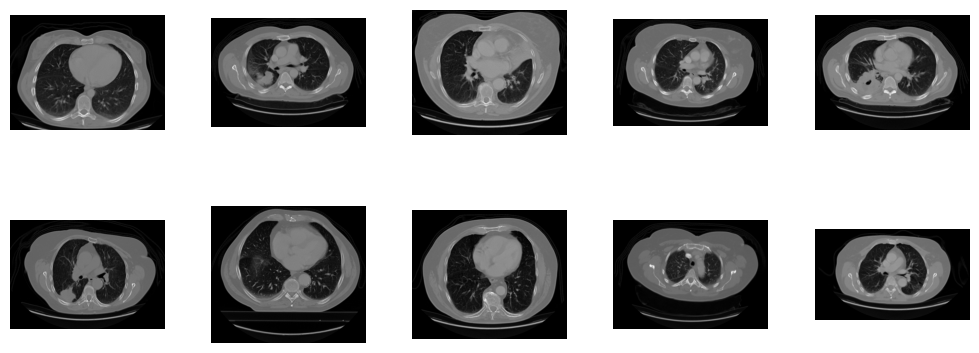

In [ ]:
img_directory = r'/content/drive/MyDrive/dataset/Data/test/adenocarcinoma'
plot_images(img_directory, top=10)

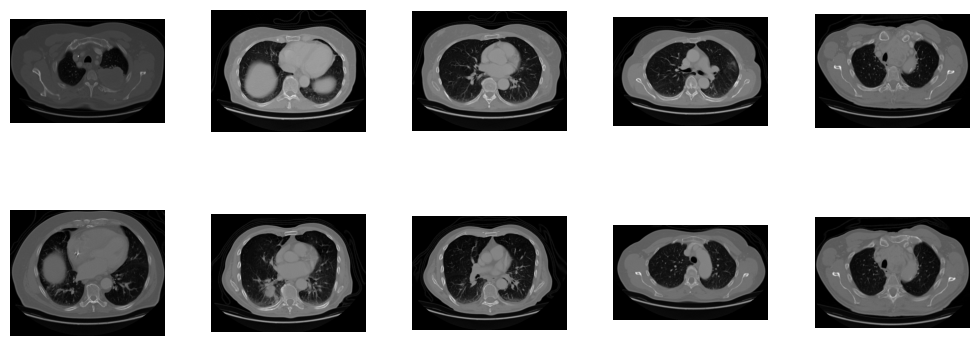

In [ ]:
img_directory = r'/content/drive/MyDrive/dataset/Data/test/large.cell.carcinoma'
plot_images(img_directory, top=10)

#**Pre-processing**

In [ ]:
# Specify the directory containing your images
input_directory = '/content/drive/MyDrive/dataset/Data/test/normal'

# Specify the new width and height for resizing
new_width = 300
new_height = 200

# Create an output directory for resized images
output_directory = 'resize'
os.makedirs(output_directory, exist_ok=True)

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(input_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Resize the first 10 images
for i in range(min(10, len(image_files))):
    image_file = image_files[i]
    image_path = os.path.join(input_directory, image_file)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Specify the path for the output (resized) image
    output_path = os.path.join(output_directory, f'resized_{image_file}')

    # Save the resized image
    cv2.imwrite(output_path, resized_image)

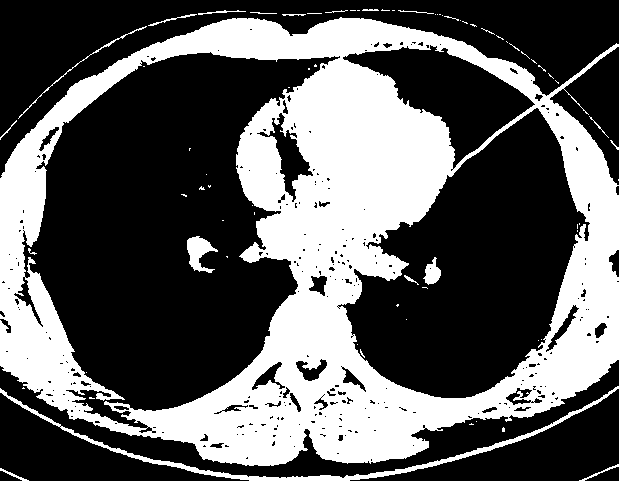

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Import the function for displaying images

# Load the image
image = cv2.imread('/content/drive/MyDrive/dataset/Data/test/normal/12 - Copy.png', 0)  # 0 flag loads the image in grayscale

# Apply thresholding
_, threshold_image = cv2.threshold(image, 125, 255, cv2.THRESH_BINARY)

# Display the threshold image
cv2_imshow(threshold_image)


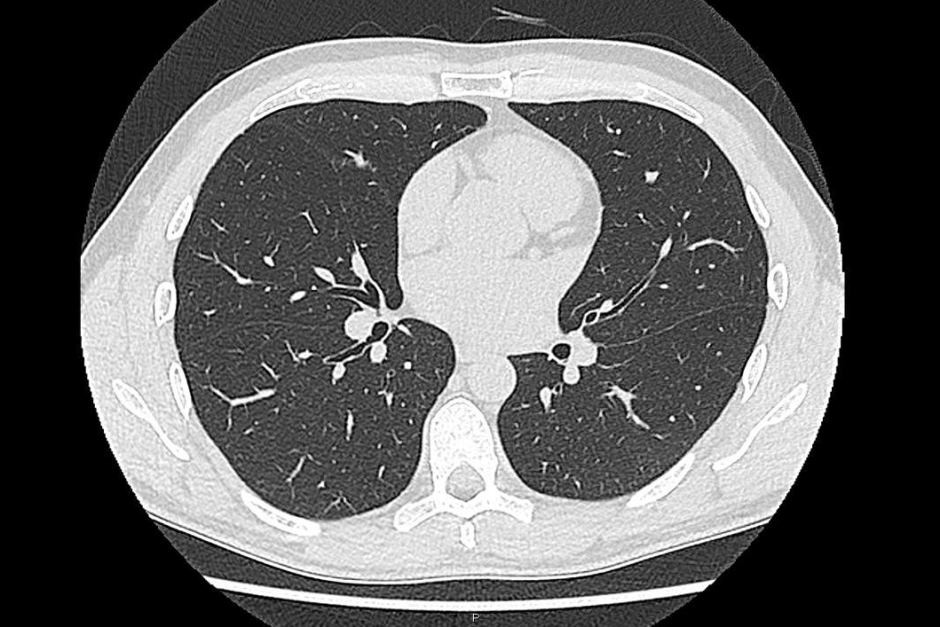

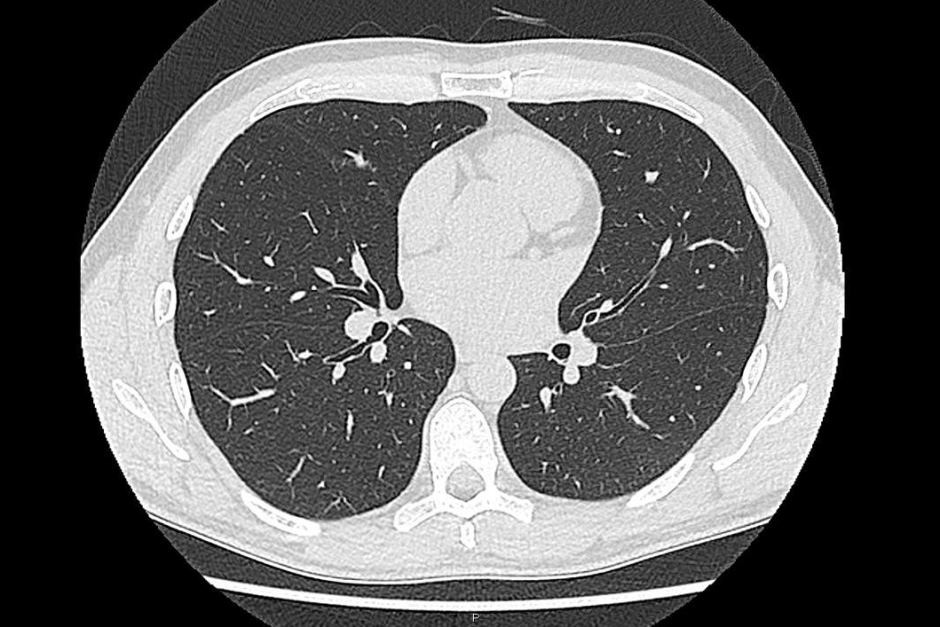

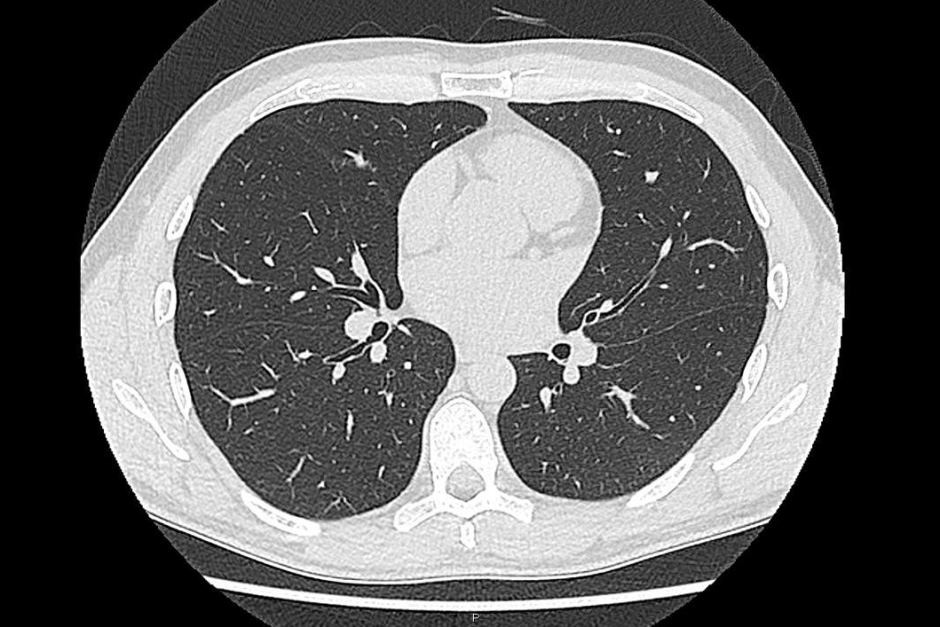

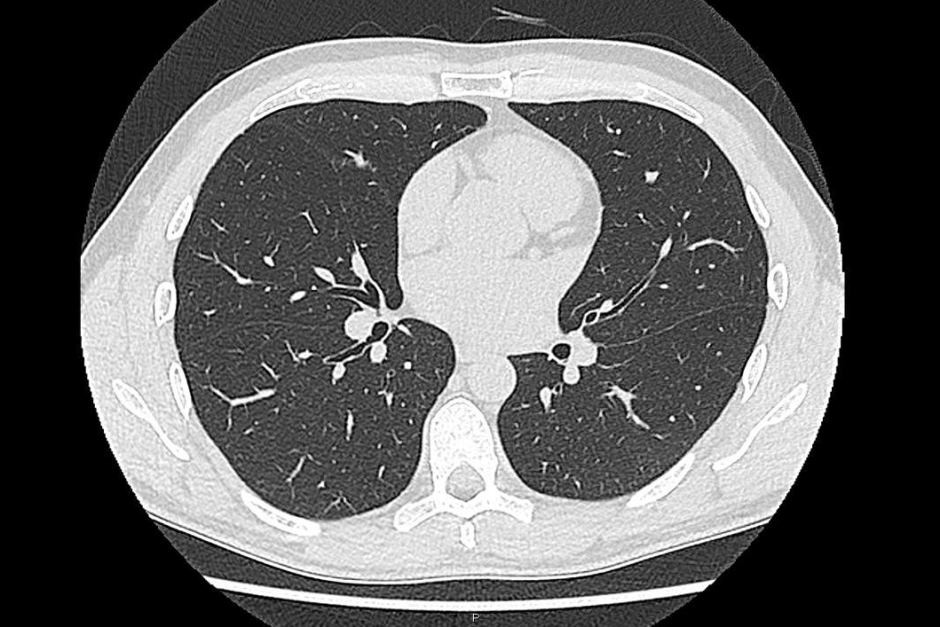

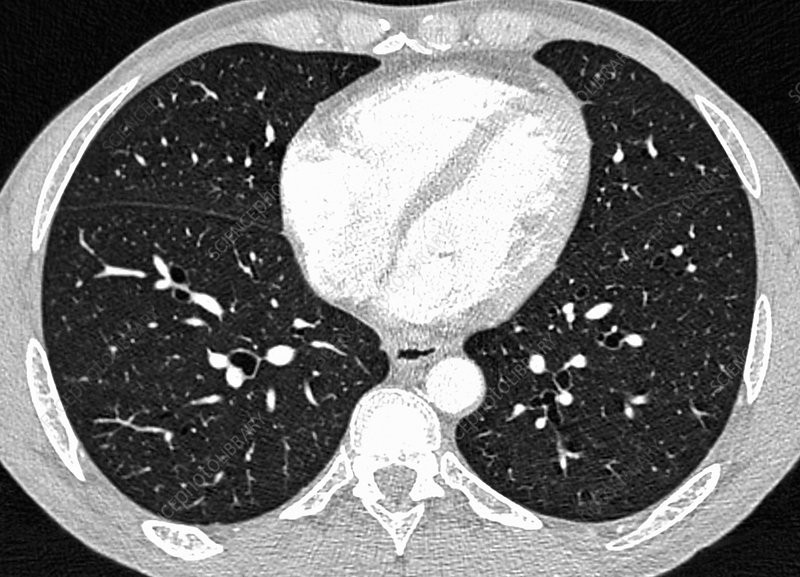

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow  # Import the function for displaying images

# Define the folder path
folder_path = '/content/drive/MyDrive/dataset/Data/train/normal'  # Replace this with the actual path to your folder

# Get a list of all the image files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Sort the image files by size (you can also sort by creation date, modification date, etc.)
image_files.sort(key=lambda f: os.path.getsize(os.path.join(folder_path, f)), reverse=True)

# Load and display the top 5 images
for i in range(min(5, len(image_files))):
    image_path = os.path.join(folder_path, image_files[i])
    image = cv2.imread(image_path)
    cv2_imshow(image)



In [ ]:
import cv2 as cv
def load_and_sharpen_images_from_subdirectories(parent_directory, subdirectories, target_size=(224, 224)):
    images = []
    labels = []  # Store corresponding labels
    for subdir in subdirectories:
        subdir_path = os.path.join(parent_directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            image_path = os.path.join(subdir_path, file)
            if os.path.isfile(image_path):
                # Read image in grayscale
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
                if image is not None:

                    # Convert grayscale to RGB by replicating the single channel to three channels
                    image_rgb = cv.merge((image, image, image))

                    # Resize to target size
                    image_resized = cv.resize(image_rgb, target_size)
                    # print(image_resized.shape)
                    images.append(image_resized)

                    # Assign label based on directory name
                    if subdir == 'normal':
                        labels.append([1, 0])  # Non-cancerous label (1, 0) for one-hot encoding
                    else:
                        labels.append([0, 1])  # Cancerous label (0, 1) for one-hot encoding
    print(images[0].shape)

    return np.array(images), np.array(labels)


#**Train-Test Split**

In [ ]:
train_dir = '/content/drive/MyDrive/dataset/Data/train'
valid_dir = '/content/drive/MyDrive/dataset/Data/valid'
test_dir = '/content/drive/MyDrive/dataset/Data/test'

subdirectories = ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

In [ ]:
train_images,train_labels = load_and_sharpen_images_from_subdirectories(train_dir, subdirectories)
valid_images,valied_labels = load_and_sharpen_images_from_subdirectories(valid_dir, subdirectories)
test_images,test_labels = load_and_sharpen_images_from_subdirectories(test_dir, ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
print("Number of loaded train images:", len(train_images))
print("Number of loaded test images:", len(test_images))
print("Number of loaded valid images:", len(valid_images))

Number of loaded train images: 613
Number of loaded test images: 315
Number of loaded valid images: 72


#**Optimized Resnet - 50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
import time
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

# Record start time
start_time = time.time()

def ModifiedResNet(input_shape=(224, 224, 3), n_classes=2, first_layer_kernel=7,
                   first_layer_downsampling=True, first_pooling=(3, 3),
                   residual_blocks=((256, 3), (512, 4), (1024, 6), (2048, 3)),
                   bottleneck=True, l2_weight=1e-4):

    # initial Conv2D
    first_filter = residual_blocks[0][0]
    first_stride = 2 if first_layer_downsampling else 1

    x_in = Input(shape=input_shape)
    x = layers.Conv2D(first_filter, kernel_size=first_layer_kernel, strides=first_stride,
                      padding='same', kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_weight))(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if first_pooling is not None:
        x = layers.MaxPool2D(pool_size=first_pooling, strides=(2, 2), padding='same')(x)

    # Residual blocks
    for n, (n_channels, repeats) in enumerate(residual_blocks):
        x = ModifiedResidualBlock(x, n_channels, repeats, bottleneck, n != 0, l2_weight)

    # classifier
    x = layers.GlobalAveragePooling2D()(x)
    x_out = layers.Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=x_in, outputs=x_out)
    return model


def ModifiedResidualBlock(x, n_channels, repeats, bottleneck=False, downsampling=True, l2_weight=1e-4):
    # downsampling only happens in the beginning of each block
    if bottleneck:
        for r in range(repeats):
            if r == 0:
                x = ModifiedBottleneckLayer(x, n_channels, downsampling=downsampling, l2_weight=l2_weight)
            else:
                x = ModifiedBottleneckLayer(x, n_channels, downsampling=False, l2_weight=l2_weight)
    else:
        for r in range(repeats):
            if r == 0:
                x = ModifiedSimpleLayer(x, n_channels, downsampling=downsampling, l2_weight=l2_weight)
            else:
                x = ModifiedSimpleLayer(x, n_channels, downsampling=False, l2_weight=l2_weight)
    return x


def ModifiedSimpleLayer(x_in, n_channels, downsampling=False, l2_weight=1e-4):
    x = layers.Conv2D(n_channels, (3, 3), strides=(2, 2) if downsampling else (1, 1),
                      padding='same', kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_weight))(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def ModifiedBottleneckLayer(x_in, n_channels, downsampling=False, l2_weight=1e-4):
    x = layers.Conv2D(n_channels // 4, (1, 1), strides=(1, 1),
                      padding='same', kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_weight))(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(n_channels // 4, (3, 3), strides=(2, 2) if downsampling else (1, 1),
                      padding='same', kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(n_channels, (1, 1), strides=(1, 1),
                      padding='same', kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)

    if downsampling:
        x_tmp = layers.Conv2D(n_channels, kernel_size=(1, 1), strides=(2, 2),
                              padding='same', kernel_initializer='he_uniform',
                              kernel_regularizer=l2(l2_weight))(x_in)
        x = layers.Add()([x, x_tmp])
    else:
        x = layers.Add()([x, x_in])
    x = layers.ReLU()(x)
    return x

# Define input shape
input_shape = (224, 224, 3)

# Create ResNet-50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Record end time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
epochs = 3

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

Epoch 1/3
20/20 [==============================] - 13s 248ms/step - loss: 1.3719 - accuracy: 0.7961 - val_loss: 6.1756e-04 - val_accuracy: 1.0000
Epoch 2/3
20/20 [==============================] - 2s 94ms/step - loss: 0.1717 - accuracy: 0.9560 - val_loss: 0.0187 - val_accuracy: 0.9861
Epoch 3/3
20/20 [==============================] - 2s 102ms/step - loss: 0.0332 - accuracy: 0.9853 - val_loss: 0.0441 - val_accuracy: 0.9722


#**Resnet-50**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
import time

# Record start time
start_time = time.time()

# Define input shape
input_shape = (224, 224, 3)

# Create ResNet-50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # assuming 2 classes for binary classification

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # use categorical crossentropy for multi-class classification
              metrics=['accuracy'])

# Display model summary
model.summary()

# Record end time
end_time = time.time()

# Print elapsed time
print("Elapsed time:", end_time - start_time, "seconds")


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
epochs = 3

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

Epoch 1/3
20/20 [==============================] - 7s 148ms/step - loss: 0.1595 - accuracy: 0.9445 - val_loss: 0.2858 - val_accuracy: 0.9167
Epoch 2/3
20/20 [==============================] - 2s 97ms/step - loss: 0.0725 - accuracy: 0.9739 - val_loss: 0.1607 - val_accuracy: 0.9722
Epoch 3/3
20/20 [==============================] - 2s 103ms/step - loss: 0.1413 - accuracy: 0.9674 - val_loss: 0.0617 - val_accuracy: 0.9861
